# Testing Hadamard MGP with GPytorch

In [414]:
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2,
], -1)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 100 and 20 in dimension 0 at ../aten/src/TH/generic/THTensor.cpp:689

In [415]:
from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)

def generate_dataset(n_samples=5, n_tasks=3):
    """
    Generating Variable Length, Irregularly observed Time Series (with sine and cosine)
    Returns:
    -data dict:
        'x':
            'task_0': list of tensors
            'task_1': ..
             .. (n_tasks-1)
        'y': 
            'task_0': list of tensors
            'task_1': ..
             .. (n_tasks-1)
    list elements represent samples / instances
    """
    #first draw number of observations per sample (uniform between 20 and 50)
    lengths = torch.randint(50, 150, (n_tasks,n_samples))
    data = nested_dict()
    for i, length in enumerate(lengths): #loop over tasks
        x_list = []
        y_list = []
        for j, l in enumerate(length): #loop over samples
            x = torch.rand(l)
            if i % 2 == 0: #even tasks with sin, uneven with cos
                y = torch.sin(torch.randn(1) + x * (10*torch.randn(1)* math.pi)) + torch.randn(x.size()) * 0.2
            else:
                y = torch.cos(torch.randn(1) + x * (10*torch.randn(1)* math.pi)) + torch.randn(x.size()) * 0.2
            x_list.append(x)
            y_list.append(y)
        data['x']['task_' + str(i)] = x_list
        data['y']['task_' + str(i)] = y_list
    return data
    

In [434]:
n_tasks=3
data = generate_dataset(n_tasks=n_tasks)

In [435]:
def plot_data(data):
    n_samples = len(data['x']['task_0'])
    n_tasks = len(list(data['x'].keys()))
    fig, ax = plt.subplots(n_samples, figsize=(10,10))
    for i in np.arange(n_samples):
        for j in np.arange(n_tasks):  
            x = data['x']['task_'+str(j)][i]
            y = data['y']['task_'+str(j)][i]
            ax[i].plot(x,y, 'o')

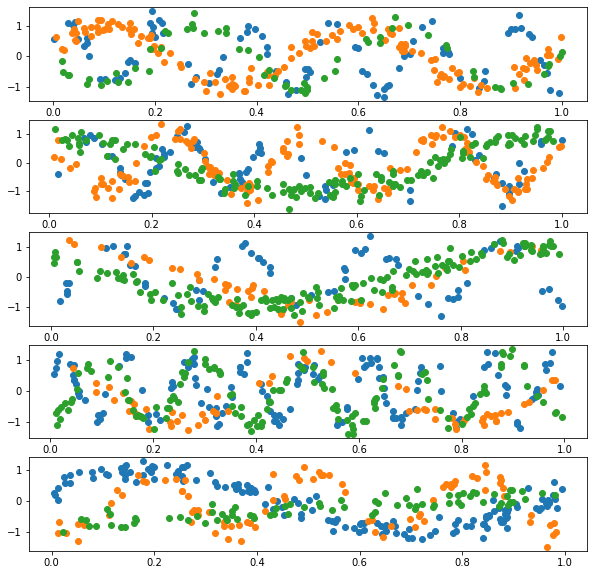

In [436]:
plot_data(data)

In [437]:
def pad_data(data_list, fill=0):
    """
    Pad tensors with fill-value such that list of variable shaped tensors can be stacked
    """
    n_samples = len(data_list)
    #first determine longest time series:
    lengths = [x.shape[0] for x in data_list]
    max_len = max(lengths)
    
    output = fill*torch.ones((n_samples, max_len))
    for i in np.arange(n_samples):
        output[i,:lengths[i]] = data_list[i]
    return output
        

In [438]:
def merge_tasks(data):
    """
    For GPyTorch MGP, the tasks need to be merged into one tensor, and a index tensor identifies the task at hand
    Inputs:
    - data: nested dictionary, from generate_dataset()
    Returns:
    - x: [n_samples, len_all_tasks]
    - y: [n_samples, len_all_tasks] 
    - task_indices: [n_samples, len_all_tasks] 
    
    """
    n_samples = len(data['x']['task_0'])
    n_tasks = len(list(data['x'].keys()))
    
    #first determine maximal length of all tasks
    inputs_samples = [] # as final output size is not known here, we append all data to list..
    values_samples = []
    indices_samples = [] 
   
    for i in np.arange(n_samples):
        indices_list = []
        inputs_list = []
        values_list = []
        for j in np.arange(n_tasks):
            x = data['x']['task_' + str(j)][i]
            y = data['y']['task_'+str(j)][i]
            task_index = torch.full_like(x, dtype=torch.long, fill_value=j)
            #Append data per task into one list, and then concatenate it
            inputs_list.append(x)
            values_list.append(y)
            indices_list.append(task_index)
        #Get tensor of current sample
        inputs = torch.cat(inputs_list)
        values = torch.cat(values_list)
        indices = torch.cat(indices_list)

        #Append all tensors to list over samples
        inputs_samples.append(inputs)
        values_samples.append(values)
        indices_samples.append(indices)
    
    return  pad_data(inputs_samples), pad_data(values_samples), pad_data(indices_samples,0).to(dtype=torch.long)
    #we pad the task indices with 99 as an exotic number, to not mix it up with real tasks
    

In [480]:
inputs, values, indices = merge_tasks(data)


In [481]:
# GPyTorch seems to require additional dim for inputs
inputs = inputs.unsqueeze(-1)
indices = indices.unsqueeze(-1)

## Debugging:

In [446]:
#stick to single sample:
inputs, values, indices = inputs[0], values[0], indices[0]

In [482]:
inputs.size(), values.size(), indices.size()

(torch.Size([5, 371, 1]), torch.Size([5, 371]), torch.Size([5, 371, 1]))

In [483]:
inputs.type(), values.type(), indices.type()

('torch.FloatTensor', 'torch.FloatTensor', 'torch.LongTensor')

In [412]:
#Debugging:
train_x1 = torch.rand(180)
train_x2 = torch.rand(180)
train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2
train_i_task1 = torch.full_like(train_x1, dtype=torch.long, fill_value=0)
train_i_task2 = torch.full_like(train_x2, dtype=torch.long, fill_value=1)

inputs = torch.cat([train_x1, train_x2])
indices = torch.cat([train_i_task1, train_i_task2])
values = torch.cat([train_y1, train_y2])

# MGP Model

In [484]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks=2):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [485]:
# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((inputs, indices), values, likelihood, num_tasks=n_tasks)

In [486]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(inputs, indices)
    loss = -mll(output, values).mean()
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.015
Iter 2/50 - Loss: 0.994
Iter 3/50 - Loss: 0.973
Iter 4/50 - Loss: 0.953
Iter 5/50 - Loss: 0.935
Iter 6/50 - Loss: 0.917
Iter 7/50 - Loss: 0.899
Iter 8/50 - Loss: 0.883
Iter 9/50 - Loss: 0.867
Iter 10/50 - Loss: 0.851
Iter 11/50 - Loss: 0.834
Iter 12/50 - Loss: 0.816
Iter 13/50 - Loss: 0.799
Iter 14/50 - Loss: 0.782
Iter 15/50 - Loss: 0.768
Iter 16/50 - Loss: 0.747
Iter 17/50 - Loss: 0.724
Iter 18/50 - Loss: 0.698
Iter 19/50 - Loss: 0.672
Iter 20/50 - Loss: 0.642
Iter 21/50 - Loss: 0.613
Iter 22/50 - Loss: 0.578
Iter 23/50 - Loss: 0.540
Iter 24/50 - Loss: 0.500
Iter 25/50 - Loss: 0.466
Iter 26/50 - Loss: 0.421
Iter 27/50 - Loss: 0.358
Iter 28/50 - Loss: 0.309
Iter 29/50 - Loss: 0.289
Iter 30/50 - Loss: 0.267
Iter 31/50 - Loss: 0.257
Iter 32/50 - Loss: 0.253
Iter 33/50 - Loss: 0.237
Iter 34/50 - Loss: 0.219
Iter 35/50 - Loss: 0.203
Iter 36/50 - Loss: 0.176
Iter 37/50 - Loss: 0.161
Iter 38/50 - Loss: 0.154
Iter 39/50 - Loss: 0.141
Iter 40/50 - Loss: 0.113
Iter 41/5

RuntimeError: shape '[5, 5]' is invalid for input of size 1855

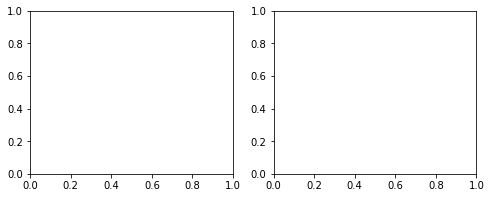

In [458]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1, 51)
tast_i_task1 = torch.full_like(test_x, dtype=torch.long, fill_value=0)
test_i_task2 = torch.full_like(test_x, dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x, tast_i_task1))
    observed_pred_y2 = likelihood(model(test_x, test_i_task2))

# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, 'Observed Values (Likelihood)')



In [147]:
Train_x = train_x.unsqueeze(0).repeat(4,1)

In [212]:
shifts = torch.tensor([1,-0.5,0,0.7]).unsqueeze(-1)
frequencies = torch.tensor([2,0.5,3,1]).unsqueeze(-1)

In [231]:
Train_y = torch.stack([
    torch.sin(Train_x * (2*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
    torch.cos(Train_x * (3*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
], -1)

In [244]:
a = torch.tensor(float('nan')) 

In [249]:
Train_y[0,0,0] = float('nan')

In [252]:
def plot_data(Train_x, Train_y):
    n_samples = Train_x.shape[0]
    fig, ax = plt.subplots(n_samples, figsize=(10,10))
    for i, (x,y) in enumerate(zip(Train_x, Train_y)):
        ax[i].plot(x,y)
        

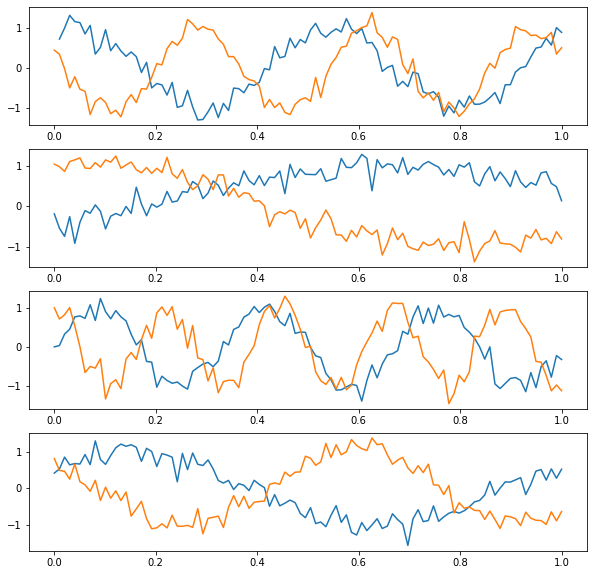

In [253]:
plot_data(Train_x, Train_y)

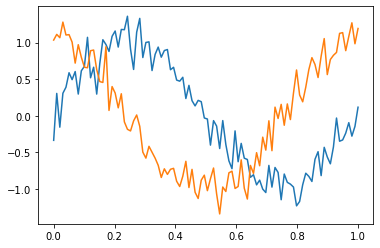

In [142]:
plt.plot(train_x, train_y)

# Kronecker MGP here

In [92]:
#MGP Model Class
class MultitaskGPModel(gpytorch.models.ExactGP ):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [254]:
train_x = Train_x
train_y = Train_y

In [255]:
train_x = train_x.unsqueeze(-1)

In [256]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [257]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).mean() #.mean()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

RuntimeError: NaNs encounterd when trying to perform matrix-vector multiplication

In [223]:
for param_name, param in model.named_parameters():
    print(f'Name: {param_name} Value = {param.data}')

Name: likelihood.raw_noise Value = tensor([-3.9215])
Name: likelihood.noise_covar.raw_noise Value = tensor([-3.8298, -4.0096])
Name: mean_module.base_means.0.constant Value = tensor([0.1997])
Name: mean_module.base_means.1.constant Value = tensor([0.1597])
Name: covar_module.task_covar_module.covar_factor Value = tensor([[ 0.5300],
        [-0.0372]])
Name: covar_module.task_covar_module.raw_var Value = tensor([-1.1952, -0.1046])
Name: covar_module.data_covar_module.raw_lengthscale Value = tensor([[-2.1759]])


In [241]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).unsqueeze(0).repeat(4,1).unsqueeze(-1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


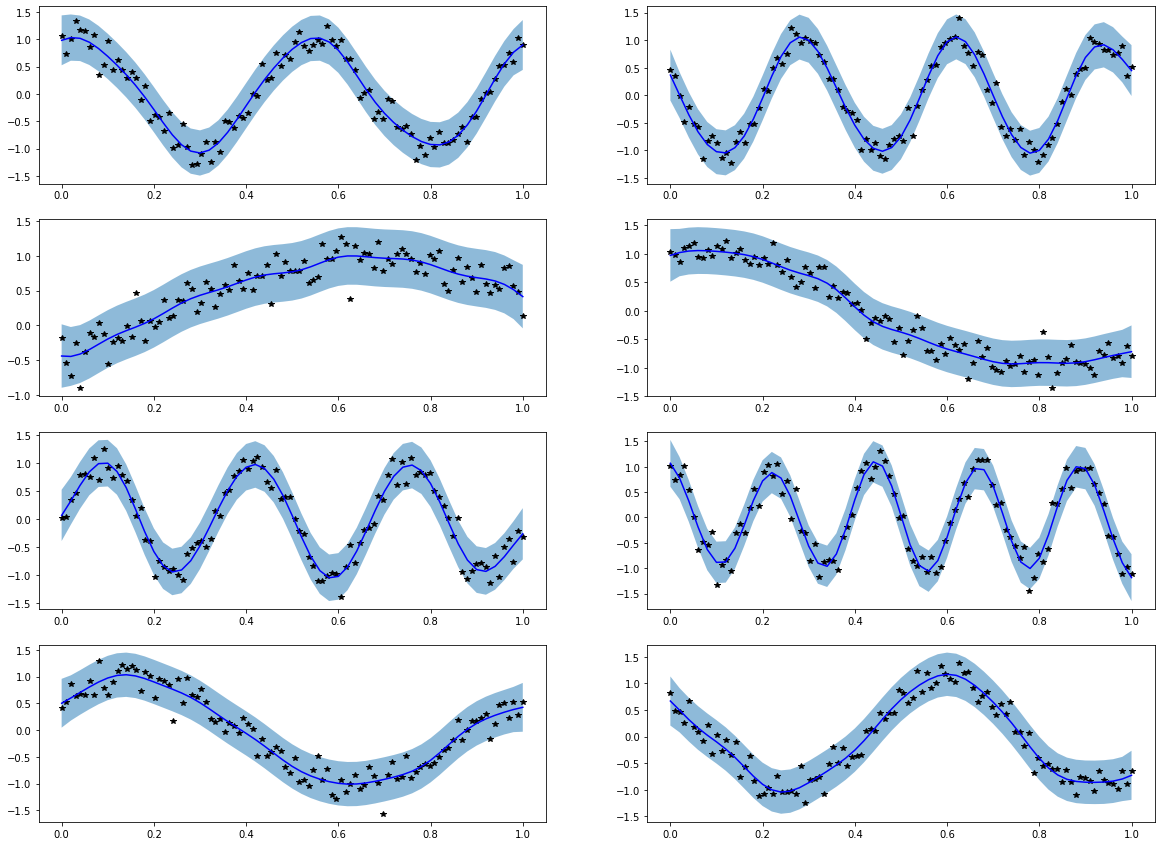

In [242]:
# Initialize plots
f, ax = plt.subplots(4, 2, figsize=(20, 15))

n_samples = test_x.shape[0]
n_tasks = train_y.shape[-1]
for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        ax[i,j].plot(train_x[i].detach().numpy(), train_y[i,:,j].detach().numpy(), 'k*')
        
        # Predictive mean as blue line
        ax[i,j].plot(test_x[i].numpy(), mean[i,:,j].numpy(), 'b')
        # Shade in confidence
        ax[i,j].fill_between(test_x[i].numpy().squeeze(), lower[i,:,j].numpy(), upper[i,:,j].numpy(), alpha=0.5)
        #ax[i,j].set_ylim([-3, 3])
        #ax[i,j].legend(['Observed Data', 'Mean', 'Confidence'])
        #ax[i,j].set_title('Observed Values (Likelihood)')


(51,)

In [ ]:
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')